## Forecasting U.S. natural gas prices

## 2. Data

In [171]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [172]:
# Load your dataset
gas = pd.read_csv("data/MHHNGSP.csv")
gas['observation_date'] = pd.to_datetime(gas['observation_date'])
gas.set_index('observation_date', inplace=True)
gas = gas.asfreq('MS')  # monthly data
gas.rename(columns={'MHHNGSP': 'price'}, inplace=True)

Treat this series as monthly data, with observations corresponding to the start of each month

In [173]:
print(gas.head())
print(gas.tail())
print(f"Observations: {gas.notna().sum()}")

                  price
observation_date       
1997-01-01         3.45
1997-02-01         2.15
1997-03-01         1.89
1997-04-01         2.03
1997-05-01         2.25
                  price
observation_date       
2025-06-01         3.02
2025-07-01         3.20
2025-08-01         2.91
2025-09-01         2.97
2025-10-01         3.19
Observations: price    346
dtype: int64


In [174]:
len(gas)

346

In [175]:
# Check gaps
expected = pd.date_range(gas.index.min(), gas.index.max(), freq="MS")
missing = expected.difference(gas.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


### Plot price 

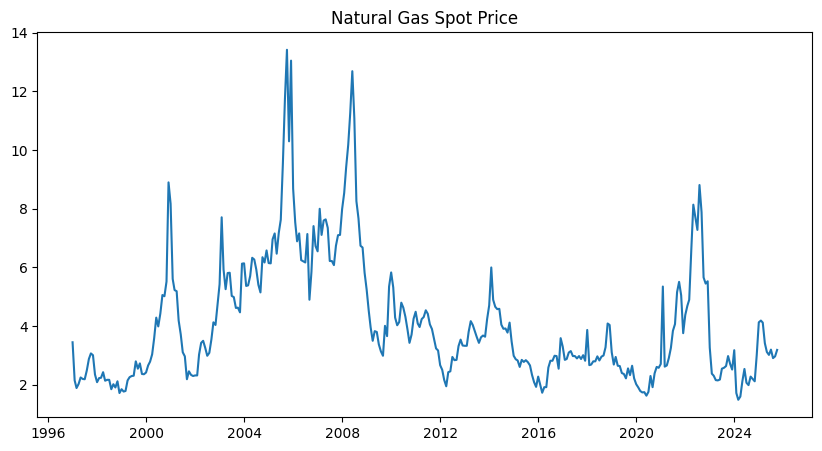

In [176]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['price'], label='Price')
plt.title("Natural Gas Spot Price")
plt.show()

### Logarithmic transformation of gas price

- Variable: Henry Hub natural gas spot price (USD/MMBtu), monthly, NSA
- Transforms: log(p_t)

In [177]:
gas['log_price'] = np.log(gas['price'])

### Plot log gas price

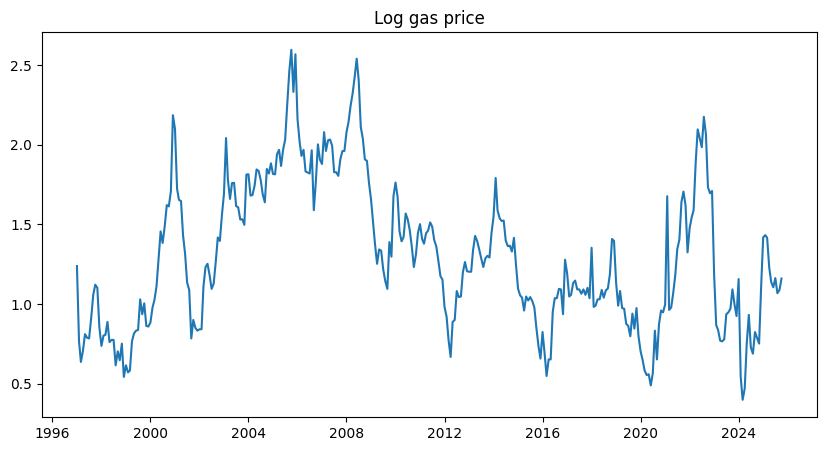

In [178]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['log_price'], label='Log Price')
plt.title("Log gas price")
plt.show()

### ACF and PACF of Log gas price

In [179]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

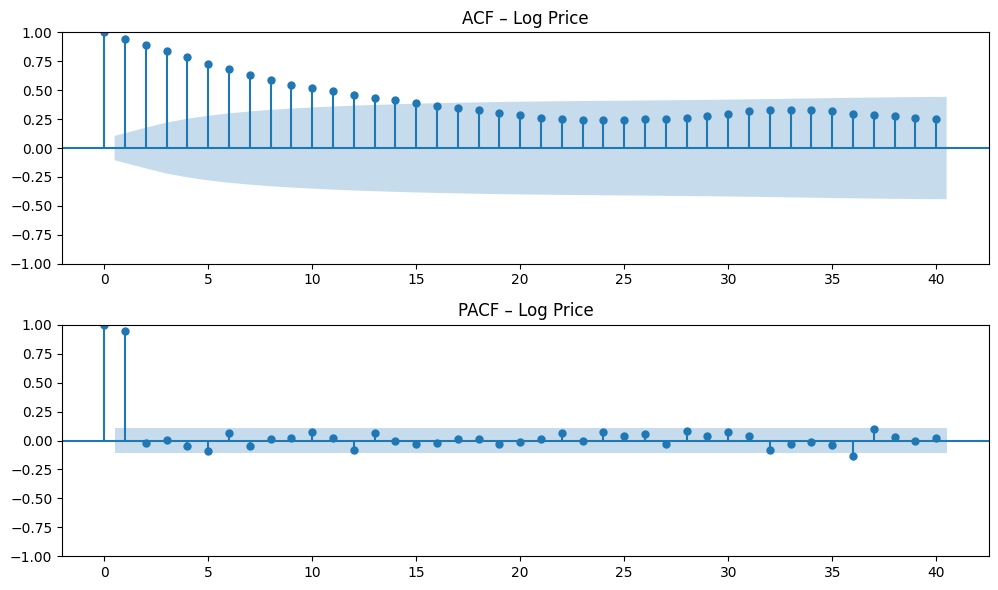

In [180]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['log_price'].dropna(), lags=40, ax=ax[0])
# ACF to see seasonal spikes at lag 12, 24
ax[0].set_title("ACF – Log Price")
plot_pacf(gas['log_price'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Log Price")
plt.tight_layout()
plt.show()


### ACF/PACF of differenced log price

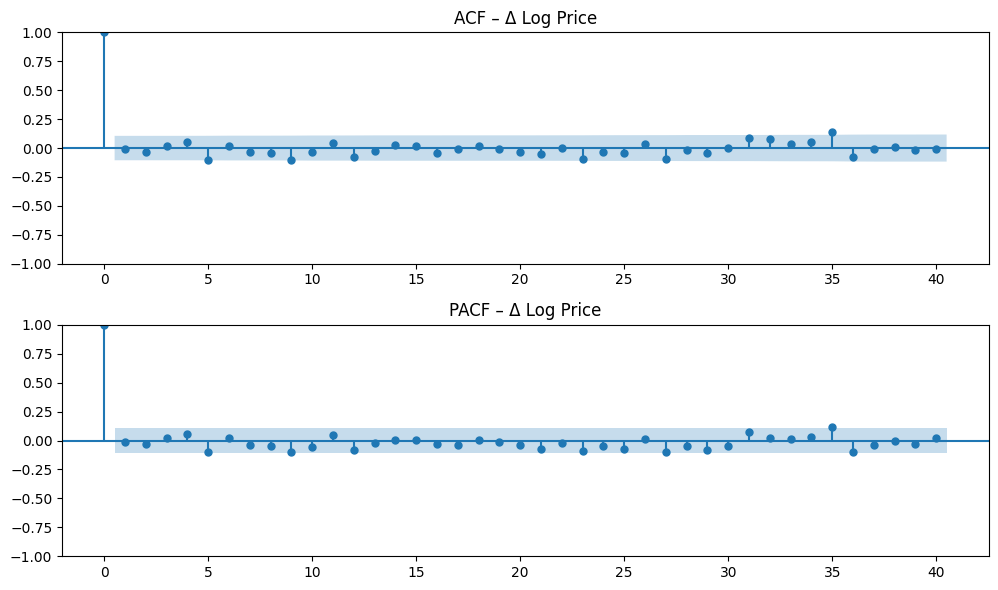

In [181]:
gas['dlog'] = gas['log_price'].diff()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['dlog'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF – Δ Log Price")
plot_pacf(gas['dlog'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Δ Log Price")
plt.tight_layout()
plt.show()

### Check stationarity with DF test on log_price and dlog

DF (Dickey–Fuller) test: H₀ = unit root (non-stationary). Low p-value → reject non-stationary → stationary.

In [182]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = gas['log_price']
dlog_x = gas['dlog']

print("Log series:")
print("  ADF :", run_adf(log_x))

Log series:
  ADF : {'stat': np.float64(-3.094343749296179), 'pvalue': np.float64(0.02697461797215903)}


## 3. Methods and models

### Model selection and justification

In [183]:
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as pdr

For all models, we generate 1-step-ahead forecasts using a recursive expanding-window approach.
- At forecast origin t, each model is re-estimated using all observations from the beginning of the sample up to t−1.

### 3.1 Benchmark models

Train/test split with last 20% as holdout

In [184]:
# Ensure y is your monthly series (MS) with float dtype, as in your code
n = len(gas['log_price'].dropna())
h_test = max(1, int(np.floor(0.20 * n)))  # 20% holdout
y_train = gas['log_price'].iloc[:-h_test]
y_test  = gas['log_price'].iloc[-h_test:]

print(f"Train: {y_train.index[0].date()} → {y_train.index[-1].date()}  (n={len(y_train)})")
print(f"Test : {y_test.index[0].date()} → {y_test.index[-1].date()}    (n={len(y_test)})")

Train: 1997-01-01 → 2020-01-01  (n=277)
Test : 2020-02-01 → 2025-10-01    (n=69)


### AIC/BIC model selection for univariate ARIMA on log_price

In [185]:
y_train_series = y_train  # just to have a clear name

candidate_orders = [
    (1, 0, 0),
    (2, 0, 0),
    (1, 0, 1),
    (0, 0, 1)
]

results_uni = []

for order in candidate_orders:
    model = ARIMA(y_train_series, order=order)
    fit   = model.fit()
    results_uni.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_uni_df = pd.DataFrame(results_uni).sort_values("aic")
print(aic_uni_df)

best_order_uni = aic_uni_df.iloc[0]["order"]
print("Chosen univariate ARIMA order (p,d,q):", best_order_uni)


       order         aic         bic
0  (1, 0, 0) -328.446992 -317.574940
1  (2, 0, 0) -326.754998 -312.258928
2  (1, 0, 1) -326.735584 -312.239514
3  (0, 0, 1)   84.216137   95.088190
Chosen univariate ARIMA order (p,d,q): (1, 0, 0)


Helper: expanding-window ARIMA forecaster
- We'll use this for the benchmark and AR(1)

In [186]:
def rolling_arima_forecast(y, order, train_size, trend='n'):
    """
    Recursive expanding-window 1-step-ahead forecasts.
    y: Series (e.g. log_price)
    order: (p,d,q)
    train_size: initial length of training sample
    trend: 'n' (no trend), 't' (linear trend), 'ct' (const + trend for d=0)
    """
    y = y.dropna()
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train = y.iloc[:i]
        model = ARIMA(y_train, order=order, trend=trend)
        fit = model.fit()
        f = fit.forecast(steps=1)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals = y.iloc[train_size:]
    return forecasts, actuals


In [187]:
def forecast_metrics(actual, forecast):
    """
    Compute RMSFE and MAFE for 1-step-ahead forecasts.

    actual: pd.Series or np.array with realized values
    forecast: pd.Series or np.array with forecast values
    """
    # make sure they align
    actual = np.asarray(actual)
    forecast = np.asarray(forecast)

    error = forecast - actual   # or actual - forecast, just be consistent
    rmsfe = np.sqrt(np.mean(error**2))
    mafe  = np.mean(np.abs(error))
    return rmsfe, mafe

1.1 Random walk without drift ARIMA(0,1,0)

In [188]:
y_full = gas['log_price']
train_size = len(y_train)

f_rw_nodrift, a_rw_nodrift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='n'   # NO drift
)
rmsfe_rw_nodrift, mafe_rw_nodrift = forecast_metrics(a_rw_nodrift, f_rw_nodrift)
print("RW NO drift – RMSFE:", rmsfe_rw_nodrift, "MAFE:", mafe_rw_nodrift)


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

RW NO drift – RMSFE: 0.21008899757576888 MAFE: 0.14314705994892313


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

1.2 Random walk with drift ARIMA(0,1,0)

In [189]:
f_rw_drift, a_rw_drift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='t'   # linear trend in levels → constant drift in differences
)
rmsfe_rw_drift, mafe_rw_drift = forecast_metrics(a_rw_drift, f_rw_drift)
print("RW WITH drift – RMSFE:", rmsfe_rw_drift, "MAFE:", mafe_rw_drift)



/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

RW WITH drift – RMSFE: 0.21046870419728253 MAFE: 0.14338279026708126


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [369]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(y_full, order=(0,1,0), trend='t').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  346
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 161.053
Date:                Tue, 09 Dec 2025   AIC                           -318.106
Time:                        12:22:31   BIC                           -310.419
Sample:                    01-01-1997   HQIC                          -315.045
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002      0.008     -0.028      0.977      -0.016       0.016
sigma2         0.0230      0.001     21.362      0.000       0.021       0.025
Ljung-Box (L1) (Q):                   0.03   Jarque-

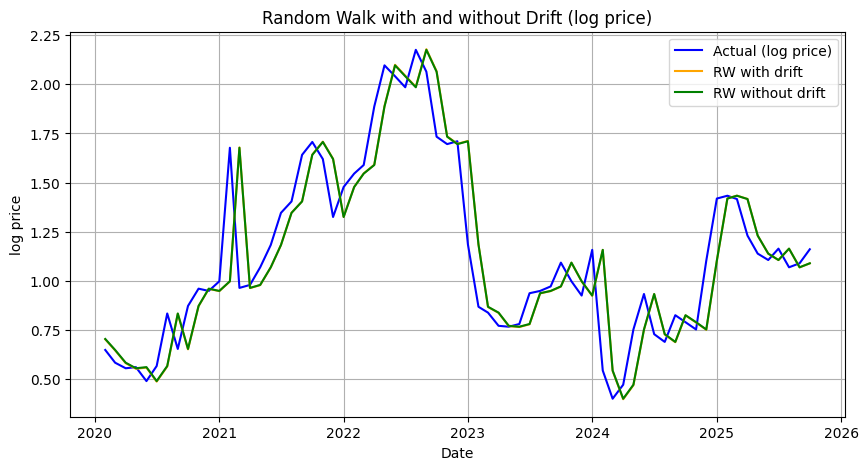

In [190]:
plt.figure(figsize=(10,5))

# Plot actual log price
plt.plot(a_rw_drift.index, a_rw_drift.values, label="Actual (log price)", color="blue")

# Plot RW with drift
plt.plot(f_rw_drift.index, f_rw_drift.values, label="RW with drift", color="orange")

# Plot RW no drift
plt.plot(f_rw_nodrift.index, f_rw_nodrift.values, label="RW without drift", color="green")

plt.title("Random Walk with and without Drift (log price)")
plt.xlabel("Date")
plt.ylabel("log price")
plt.legend()
plt.grid(True)
plt.show()

2. AR(1) on log price: ARIMA(1,0,0) 

In [191]:
f_ar1, a_ar1 = rolling_arima_forecast(
    y_full,
    order=tuple(best_order_uni),
    train_size=train_size
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2255937583.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [192]:
# Compute error and RMSFE
rmsfe_ar1, mafe_ar1 = forecast_metrics(a_ar1, f_ar1)
print("AR(1) – RMSFE:", rmsfe_ar1, "MAFE:", mafe_ar1)

AR(1) – RMSFE: 0.21008266931807196 MAFE: 0.1434842362769176


### 3.2 Alternative models

Load oil price series

In [193]:
# Load your dataset
oil = pd.read_csv("data/DCOILWTICO.csv")
oil['observation_date'] = pd.to_datetime(oil['observation_date'])
oil.set_index('observation_date', inplace=True)
oil.rename(columns={'DCOILWTICO': 'oil_price'}, inplace=True)

In [194]:
oil = oil.resample('MS').mean()

In [195]:
expected = pd.date_range(oil.index.min(), oil.index.max(), freq="MS")
missing = expected.difference(oil.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


In [196]:
print(oil.head())
print(oil.tail())
print(f"Observations: {oil.notna().sum()}")

                  oil_price
observation_date           
1997-01-01        25.131818
1997-02-01        22.176316
1997-03-01        20.965000
1997-04-01        19.695455
1997-05-01        20.819048
                  oil_price
observation_date           
2025-06-01        68.169000
2025-07-01        68.390909
2025-08-01        64.864286
2025-09-01        63.959048
2025-10-01        62.590000
Observations: oil_price    346
dtype: int64


### Plot oil

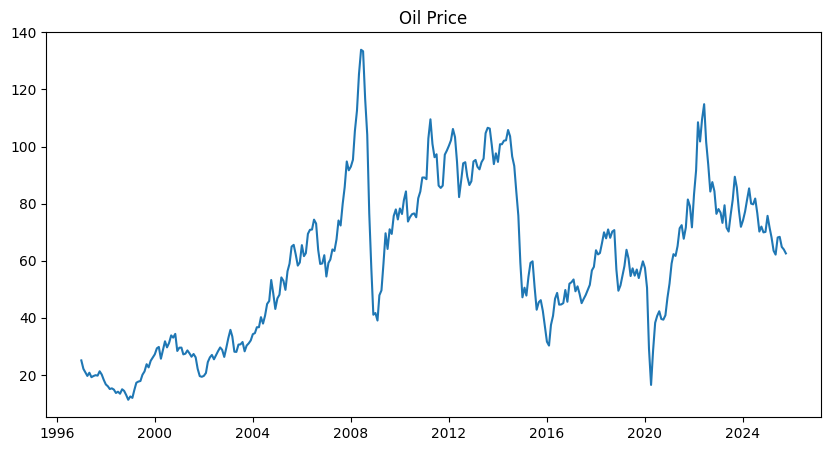

In [197]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['oil_price'], label='Price')
plt.title("Oil Price")
plt.show()

### Logarithmic transformation of oil price

In [198]:
oil['log_oil_price'] = np.log(oil['oil_price'])

In [199]:
print(oil.head())

                  oil_price  log_oil_price
observation_date                          
1997-01-01        25.131818       3.224135
1997-02-01        22.176316       3.099025
1997-03-01        20.965000       3.042854
1997-04-01        19.695455       2.980388
1997-05-01        20.819048       3.035868


### Plot log oil

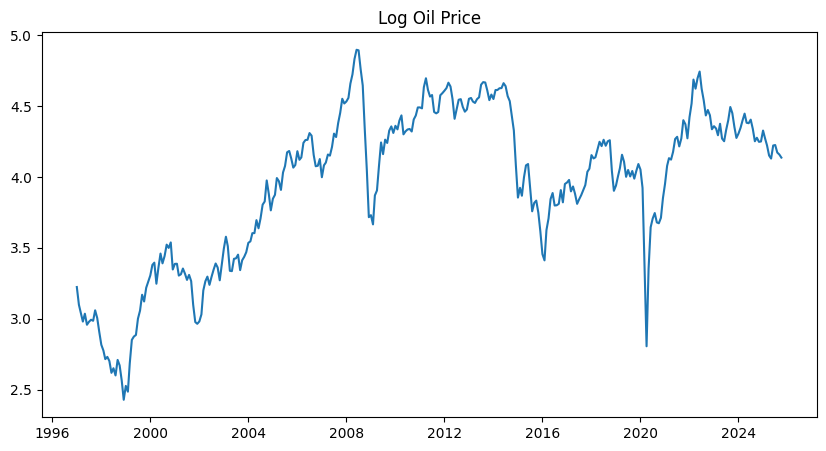

In [200]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['log_oil_price'], label='Price')
plt.title("Log Oil Price")
plt.show()

### Check stationarity with DF test on log_oil_price

In [201]:
def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = oil['log_oil_price']

print("Log series:")
print("  ADF :", run_adf(log_x))

Log series:
  ADF : {'stat': np.float64(-2.283960217429215), 'pvalue': np.float64(0.17719331464393745)}


We fail to reject the null of a unit root so the series is non-stationary

### First difference

In [202]:
oil['dlog_oil'] = oil['log_oil_price'].diff()

### Plot dlog oil price

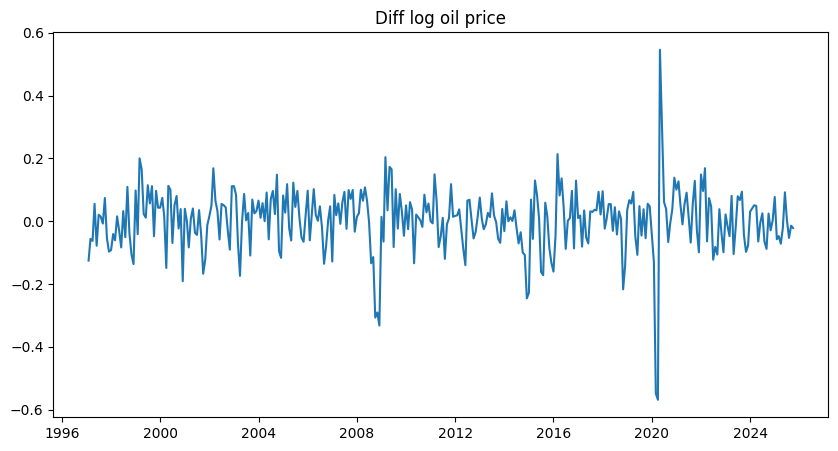

In [203]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['dlog_oil'], label='Price')
plt.title("Diff log oil price")
plt.show()

### Check stationarity with DF test on dlog_oil

In [204]:
dlog_x = oil['dlog_oil']

print("Diff series:")
print("  ADF :", run_adf(dlog_x))

Diff series:
  ADF : {'stat': np.float64(-12.521038702549626), 'pvalue': np.float64(2.5481331700962578e-23)}


P-value is essentially zero so i strongly reject the unit root null

### Merge log gas and log oil on a new dataframe 

In [205]:

df = gas[['log_price']].join(oil['log_oil_price'], how='inner')

In [206]:
df['dlog'] = df['log_price'].diff()

In [207]:
df['dlog_oil'] = df['log_oil_price'].diff()

In [208]:
df.head()

,log_price,log_oil_price,dlog,dlog_oil
observation_date,,,,
1997-01-01,1.238374,3.224135,NaN,NaN
1997-02-01,0.765468,3.099025,-0.472906,-0.125110
1997-03-01,0.636577,3.042854,-0.128891,-0.056170
1997-04-01,0.708036,2.980388,0.071459,-0.062467
1997-05-01,0.810930,3.035868,0.102894,0.055480


In [209]:
df['dlog_oil_lag1'] = df['dlog_oil'].shift(1)

In [210]:
df = df.dropna()

Split training and test set

In [211]:
N2 = len(df)
test_size2 = int(np.ceil(0.2 * N2))

train2 = df.iloc[:N2 - test_size2]
test2  = df.iloc[N2 - test_size2:]

y2_full = df['dlog']                     # Δlog gas
X2_full = df[['dlog_oil', 'dlog_oil_lag1']]    # Δlog oil, contemporaneous + lag
train_size2 = len(train2)

In [212]:
print(f"Train: {train2.index[0].date()} → {train2.index[-1].date()}  (n={len(train2)})")
print(f"Test : {test2.index[0].date()} → {test2.index[-1].date()}    (n={len(test2)})")

Train: 1997-03-01 → 2020-01-01  (n=275)
Test : 2020-02-01 → 2025-10-01    (n=69)


### AIC/BIC model selection for AR-X on dlog with oil

In [213]:
y_train2 = train2['dlog']
X_train2 = train2[['dlog_oil', 'dlog_oil_lag1']]

candidate_orders_arx = [
    (1, 0, 0),
    (2, 0, 0),
    (3, 0, 0),
    (4, 0, 0)
]

results_arx = []

for order in candidate_orders_arx:
    model = ARIMA(y_train2, order=order, exog=X_train2)
    fit   = model.fit()
    results_arx.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_arx_df = pd.DataFrame(results_arx).sort_values("aic")
print(aic_arx_df)

best_order_arx = aic_arx_df.iloc[0]["order"]
print("Chosen AR-X ARIMA order (p,d,q):", best_order_arx)


       order         aic         bic
0  (1, 0, 0) -341.099314 -323.015459
1  (2, 0, 0) -339.203465 -317.502838
2  (3, 0, 0) -337.840832 -312.523435
3  (4, 0, 0) -335.977956 -307.043787
Chosen AR-X ARIMA order (p,d,q): (1, 0, 0)


Helper: Expanding-window recursive ARIMA with exogenous regressors (AR-X)

In [214]:
def rolling_arima_exog(y, exog, order, train_size):
    """
    y: Series (dependent)
    exog: DataFrame/Series with exogenous regressors (same index as y)
    order: (p,d,q)
    """
    y = y.dropna()
    exog = exog.loc[y.index]  # align
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train   = y.iloc[:i]
        exog_train = exog.iloc[:i]
        exog_fore  = exog.iloc[i:i+1]

        model = ARIMA(y_train, order=order, exog=exog_train)
        fit   = model.fit()
        f     = fit.forecast(steps=1, exog=exog_fore)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals   = y.iloc[train_size:]
    return forecasts, actuals

### 3.2.1 Alternative model 1 - AR-X(1,1) on diff log gas with diff log oil 

In [ ]:
# Alt 2: AR-X – ARIMA(1,0,0) on dlog_price with exog oil diffs
f_arx, a_arx = rolling_arima_exog(
    y=y2_full,
    exog=X2_full,
    order=tuple(best_order_arx),
    train_size=train_size2
)



/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_29562/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Compute error and RMSFE

In [216]:
rmsfe_arx, mafe_arx = forecast_metrics(a_arx, f_arx)
print("AR-X – RMSFE:", rmsfe_arx, "MAFE:", mafe_arx)

AR-X – RMSFE: 0.21244821620354887 MAFE: 0.14715590124726158


### 3.2.2 Alternative model 2 - VAR

Build the VAR dataset & train/test split

In [217]:
from statsmodels.tsa.api import VAR

# Use only the two variables we need for VAR
var_df = df[['dlog', 'dlog_oil']].dropna()

# Train / test split (last 20% as test)
N_var = len(var_df)
test_size_var = int(np.ceil(0.2 * N_var))

train_var = var_df.iloc[:N_var - test_size_var]
test_var  = var_df.iloc[N_var - test_size_var:]

print("Train VAR:", train_var.index[0], "→", train_var.index[-1], f"(n={len(train_var)})")
print("Test VAR :", test_var.index[0],  "→", test_var.index[-1],  f"(n={len(test_var)})")

Train VAR: 1997-03-01 00:00:00 → 2020-01-01 00:00:00 (n=275)
Test VAR : 2020-02-01 00:00:00 → 2025-10-01 00:00:00 (n=69)


Model selection: choose VAR lag p using AIC/BIC

In [218]:
# VAR lag-order selection on training data
model_var = VAR(train_var)
lag_results = model_var.select_order(maxlags=6)  # try lags 1..6
print(lag_results.summary())

# choose p according to AIC (or BIC)
p_aic = lag_results.aic
p_bic = lag_results.bic
print("Lag selected by AIC:", p_aic)
print("Lag selected by BIC:", p_bic)

# pick one (say AIC)
p_var = p_aic

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -8.989     -8.962*   0.0001248      -8.978
1      -9.030      -8.950   0.0001198     -8.998*
2     -9.045*      -8.912  0.0001180*      -8.992
3      -9.029      -8.842   0.0001199      -8.954
4      -9.035      -8.795   0.0001191      -8.939
5      -9.010      -8.716   0.0001223      -8.891
6      -9.012      -8.664   0.0001220      -8.872
-------------------------------------------------
Lag selected by AIC: 2
Lag selected by BIC: 0


Recursive / expanding-window 1-step forecasts from VAR

In [219]:
def rolling_var_forecast(df, p, train_size):
    """
    df: DataFrame with columns ['dlog', 'dlog_oil']
    p: VAR lag order
    train_size: initial number of observations for the first estimation
    Returns: forecasts_df (DataFrame), actuals_df (DataFrame)
    """
    df = df.dropna()
    T = len(df)
    idx_fore = df.index[train_size:]
    forecasts = []

    for i in range(train_size, T):
        train_i = df.iloc[:i]
        model_i = VAR(train_i)
        res_i   = model_i.fit(p)
        # last p observations as initial state
        y_last = train_i.values[-p:]
        f_1 = res_i.forecast(y_last, steps=1)[0]  # 1-step ahead forecast
        forecasts.append(f_1)

    forecasts_df = pd.DataFrame(forecasts, index=idx_fore, columns=df.columns)
    actuals_df   = df.iloc[train_size:]
    return forecasts_df, actuals_df

# Use full var_df and train_size = len(train_var)
train_size_var = len(train_var)

var_forecasts, var_actuals = rolling_var_forecast(
    var_df,
    p=p_var,
    train_size=train_size_var
)


Evaluation: RMSFE & MAFE for gas equation

In [220]:
f_var_gas = var_forecasts['dlog']
a_var_gas = var_actuals['dlog']

rmsfe_var, mafe_var = forecast_metrics(a_var_gas, f_var_gas)
print("VAR – RMSFE:", rmsfe_var, "MAFE:", mafe_var)

VAR – RMSFE: 0.20884963117527816 MAFE: 0.1439890648344518


### 3.2.3. Alternative model 3 - Factor model using PCA on FRED-MD series

Load FRED-MD

In [221]:
# Load your chosen vintage (e.g., "2025-10.csv")
fred = pd.read_csv("data/2025-10-MD.csv")

# Identify the date column
date_col = "sasdate" if "sasdate" in fred.columns else "DATE"

# Drop the "Transform:" row BEFORE parsing dates
fred = fred.drop(index=0)   # This removes the tcode row

# Now parse dates safely
fred[date_col] = pd.to_datetime(fred[date_col], format="%m/%d/%Y")

# Set index
fred = fred.set_index(date_col)

# Convert all other columns to floats
fred = fred.astype(float)


In [222]:
print(fred.head())

                 RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx      RETAILx  \
sasdate                                                                    
1959-01-01  2583.560   2426.0           15.188  276676.8154  17689.23968   
1959-02-01  2593.596   2434.8           15.346  278713.9773  17819.01912   
1959-03-01  2610.396   2452.7           15.491  277775.2539  17967.91336   
1959-04-01  2627.446   2470.0           15.435  283362.7075  17978.97983   
1959-05-01  2642.720   2486.4           15.622  285307.2201  18119.82573   

             INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...  \
sasdate                                                   ...   
1959-01-01  21.9616  23.3868  22.2620  31.6664   18.9498  ...   
1959-02-01  22.3917  23.7024  22.4549  31.8987   19.0492  ...   
1959-03-01  22.7142  23.8459  22.5651  31.8987   19.4223  ...   
1959-04-01  23.1981  24.1903  22.8957  32.4019   19.5466  ...   
1959-05-01  23.5476  24.3911  23.1161  32.5567   19.9445  ...   

           

Restrict to your gas sample & remove missing columns

In [223]:
# Align FRED-MD to your gas price sample window
X_raw = fred.loc[gas.index.min(): gas.index.max()]

# Drop variables with missing values
X_raw = X_raw.dropna(axis=1, how="any")


Standardize and run PCA — extract PC1

In [224]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [225]:
# Standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X_raw)

### Factor model using PC1

In [226]:
# PCA on standardized data
pca = PCA(n_components=1)
pc1_vals = pca.fit_transform(X_std)

# PC1 series
pc1 = pd.Series(pc1_vals[:, 0], index=X_raw.index, name="PC1")

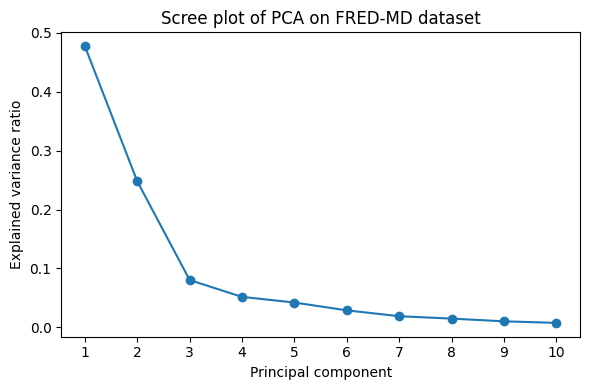

In [227]:
# Fit PCA with more components just for visualization
pca_full = PCA(n_components=10)
pca_full.fit(X_std)

expl_var = pca_full.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, len(expl_var)+1), expl_var, marker="o")
ax.set_xlabel("Principal component")
ax.set_ylabel("Explained variance ratio")
ax.set_title("Scree plot of PCA on FRED-MD dataset")
ax.set_xticks(range(1, len(expl_var)+1))
plt.tight_layout()
plt.show()

In [368]:
print("Explained variance ratio:", pca_full.explained_variance_ratio_)
print("Cumulative variance:", np.cumsum(pca_full.explained_variance_ratio_))

Explained variance ratio: [0.47758929 0.24806702 0.08033762 0.05174501 0.04211845 0.02884537
 0.01887397 0.014836   0.01019722 0.0075633 ]
Cumulative variance: [0.47758929 0.72565631 0.80599393 0.85773895 0.8998574  0.92870277
 0.94757673 0.96241273 0.97260995 0.98017325]


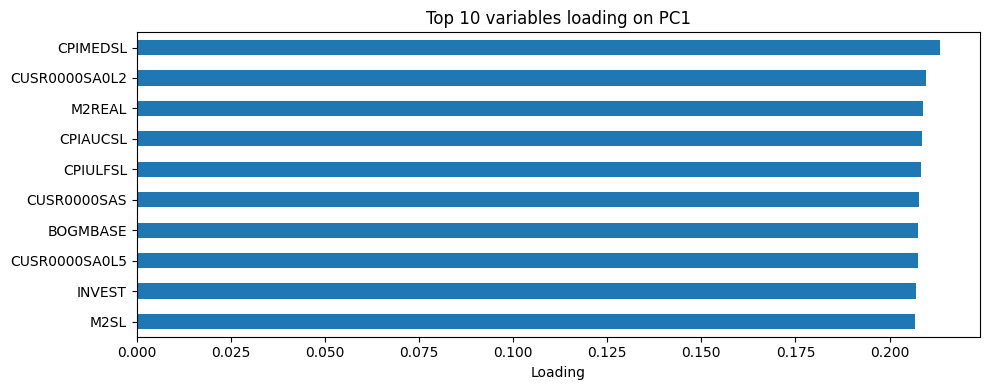

In [228]:
# Loadings of PC1 (same PCA object you used)
loadings = pd.Series(pca.components_[0], index=X_raw.columns, name="PC1_loading")

# Take variables with largest absolute loadings
top_loadings = loadings.reindex(loadings.abs().sort_values(ascending=False).head(10).index)

fig, ax = plt.subplots(figsize=(10,4))
top_loadings.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top 10 variables loading on PC1")
ax.set_xlabel("Loading")
plt.tight_layout()
plt.show()


In [229]:
pretty_names = {
    "CPIMEDSL": "CPI: Medical Care",
    "CUSR0000SA0L2": "CPI: Energy Services",
    "M2REAL": "Real M2",
    "CPIAUCSL": "CPI: All Items",
    "CPIULFSL": "CPI: All Items Less Food",
    "CUSR0000SAS": "CPI: Services",
    "BOGMBASE": "Monetary Base",
    "CUSR0000SA0L5": "CPI: Gasoline",
    "INVEST": "Investment Index",
    "M2SL": "M2 Money Stock"
}

In [230]:
# replace codes with human-readable names
top_loadings_named = top_loadings.copy()
top_loadings_named.index = top_loadings_named.index.map(lambda x: pretty_names.get(x, x))

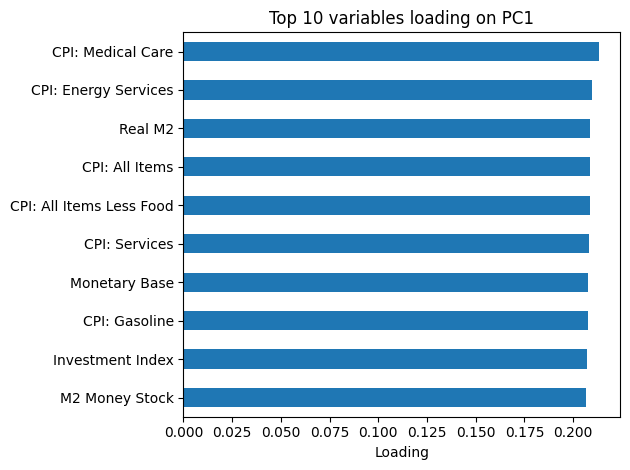

In [231]:
top_loadings_named.sort_values().plot(kind="barh")
plt.title("Top 10 variables loading on PC1")
plt.xlabel("Loading")
plt.tight_layout()
plt.show()

Build dataset for the factor model (log gas)

In [232]:
df_factor = pd.DataFrame({
    "log_gas": gas['log_price'],
    "log_gas_l1": gas['log_price'].shift(1),
    "F_l1": pc1.shift(1)       # lag the factor
}).dropna()

In [233]:
n_fac = len(df_factor)
h_test_fac = max(1, int(np.floor(0.20 * n_fac)))   # 20% holdout
train_size_fac = n_fac - h_test_fac                # 80% training

print("Total obs:", n_fac)
print("Train size (factor):", train_size_fac)
print("Test size (factor):", h_test_fac)

Total obs: 344
Train size (factor): 276
Test size (factor): 68


Recursive 1-step-ahead forecasts

In [234]:
import statsmodels.api as sm

In [235]:
def rolling_factor_forecast(df, initial_window):
    y_all = df["log_gas"]
    X_all = sm.add_constant(df[["log_gas_l1", "F_l1"]])

    actual = []
    forecast = []

    for t in range(initial_window, len(df)):
        # training sample up to t-1
        y_train = y_all.iloc[:t]
        X_train = X_all.iloc[:t]

        # 1-step-ahead: predict y_t
        X_t = X_all.iloc[t:t+1]

        model = sm.OLS(y_train, X_train).fit()
        f_hat = model.predict(X_t).iloc[0]

        actual.append(y_all.iloc[t])
        forecast.append(f_hat)

    idx = y_all.index[initial_window:]
    a_factor = pd.Series(actual, index=idx, name="actual_factor")
    f_factor = pd.Series(forecast, index=idx, name="forecast_factor")

    return a_factor, f_factor

# 80/20 split with recursive expanding window
a_fac, f_fac = rolling_factor_forecast(
    df_factor,
    initial_window=train_size_fac  # this is 80% of the sample
)

In [236]:
def forecast_metrics(actual, forecast):
    err = forecast - actual
    rmsfe = np.sqrt(np.mean(err**2))
    mafe = np.mean(np.abs(err))
    return rmsfe, mafe

In [237]:
rmsfe_fac, mafe_fac = forecast_metrics(a_fac, f_fac)
print("Factor model RMSFE:", rmsfe_fac)
print("Factor model MAFE:", mafe_fac)

Factor model RMSFE: 0.2090265417179649
Factor model MAFE: 0.1433594862132688


### Factor model using PC1 and PC2

In [238]:
# PCA with 2 components
pca_2 = PCA(n_components=2)
pc_vals = pca_2.fit_transform(X_std)

# Build PC1 and PC2 series
pc1 = pd.Series(pc_vals[:, 0], index=X_raw.index, name="PC1")
pc2 = pd.Series(pc_vals[:, 1], index=X_raw.index, name="PC2")

In [239]:
# Dataset for factor model with PC1 and PC2
df_factor2 = pd.DataFrame({
    "log_gas": gas["log_price"],
    "log_gas_l1": gas["log_price"].shift(1),
    "F1_l1": pc1.shift(1),  # lagged PC1
    "F2_l1": pc2.shift(1)   # lagged PC2
}).dropna()

df_factor2.head()

,log_gas,log_gas_l1,F1_l1,F2_l1
1997-02-01,0.765468,1.238374,-7.176676,2.143832
1997-03-01,0.636577,0.765468,-7.136673,2.356857
1997-04-01,0.708036,0.636577,-7.329767,2.517722
1997-05-01,0.810930,0.708036,-7.498533,2.669133
1997-06-01,0.788457,0.810930,-7.468825,2.733221


In [240]:
n_fac = len(df_factor2)
h_test_fac = max(1, int(np.floor(0.20 * n_fac)))   # 20% holdout
train_size_fac = n_fac - h_test_fac                # 80% training

print("Total obs:", n_fac)
print("Train size (factor):", train_size_fac)
print("Test size (factor):", h_test_fac)

Total obs: 344
Train size (factor): 276
Test size (factor): 68


In [241]:
def rolling_factor_forecast_2f(df, initial_window):
    y_all = df["log_gas"]
    # Regressors: lagged gas + 2 lagged factors
    X_all = sm.add_constant(df[["log_gas_l1", "F1_l1", "F2_l1"]])

    actual = []
    forecast = []

    for t in range(initial_window, len(df)):
        # training sample up to t-1
        y_train = y_all.iloc[:t]
        X_train = X_all.iloc[:t]

        # 1-step-ahead forecast for time t
        X_t = X_all.iloc[t:t+1]
        model = sm.OLS(y_train, X_train).fit()
        f_hat = model.predict(X_t).iloc[0]

        actual.append(y_all.iloc[t])
        forecast.append(f_hat)

    idx = y_all.index[initial_window:]
    a_fac2 = pd.Series(actual, index=idx, name="actual_fac2")
    f_fac2 = pd.Series(forecast, index=idx, name="forecast_fac2")
    return a_fac2, f_fac2

# 80/20 split with recursive expanding window
a_fac2, f_fac2 = rolling_factor_forecast_2f(
    df_factor2,
    initial_window=train_size_fac  # this is 80% of the sample
)


Compute RMSFE / MAFE and compare to AR(1)

In [242]:
rmsfe_fac2, mafe_fac2 = forecast_metrics(a_fac2, f_fac2)
print("2-factor model RMSFE:", rmsfe_fac2)
print("2-factor model MAFE:", mafe_fac2)

2-factor model RMSFE: 0.21034355960294518
2-factor model MAFE: 0.14459421818535614


## 4. Evaluation

One helper function to compare any alternative with AR(1)

In [243]:
def evaluate_against_benchmark(a_bench, f_bench, a_alt, f_alt, alt_name="alt"):
    # 1. Put everything into one DataFrame, like before
    pair = pd.concat(
        [
            a_bench.rename("a_bench"),   # AR(1) actuals  (log)
            f_bench.rename("f_bench"),   # AR(1) forecasts (log)
            a_alt.rename("a_alt"),       # AR-X actuals    (dlog)
            f_alt.rename("f_alt"),       # AR-X forecasts  (dlog)
        ],
        axis=1,
        join="inner"
    ).dropna()

    # 2. Benchmark metrics: log vs log forecast
    rmsfe_bench, mafe_bench = forecast_metrics(pair["a_bench"], pair["f_bench"])

    # 3. Alternative metrics: dlog vs dlog forecast
    rmsfe_alt,   mafe_alt   = forecast_metrics(pair["a_alt"],   pair["f_alt"])

    # 4. Ratios
    ratio_rmsfe = rmsfe_alt / rmsfe_bench
    ratio_mafe  = mafe_alt  / mafe_bench

    # 5. Print 
    print(f"{alt_name} vs AR(1)")
    print(f"Benchmark AR(1) - RMSFE: {rmsfe_bench:.6f}, MAFE: {mafe_bench:.6f}")
    print(f"{alt_name}          - RMSFE: {rmsfe_alt:.6f}, MAFE: {mafe_alt:.6f}")
    print(f"RMSFE ratio (alt / AR1): {ratio_rmsfe:.3f}")
    print(f"MAFE  ratio (alt / AR1): {ratio_mafe:.3f}")


Run it for AR-X and the Factor model

In [244]:
results = []

In [245]:
res_arx = evaluate_against_benchmark(a_ar1, f_ar1, a_arx, f_arx, alt_name="AR-X (oil)")
results.append(res_arx)


AR-X (oil) vs AR(1)
Benchmark AR(1) - RMSFE: 0.210083, MAFE: 0.143484
AR-X (oil)          - RMSFE: 0.212448, MAFE: 0.147156
RMSFE ratio (alt / AR1): 1.011
MAFE  ratio (alt / AR1): 1.026


In [246]:
res_fac = evaluate_against_benchmark(a_ar1, f_ar1, a_fac, f_fac, alt_name="Factor (PC1)")
results.append(res_fac)

Factor (PC1) vs AR(1)
Benchmark AR(1) - RMSFE: 0.211408, MAFE: 0.144442
Factor (PC1)          - RMSFE: 0.209027, MAFE: 0.143359
RMSFE ratio (alt / AR1): 0.989
MAFE  ratio (alt / AR1): 0.993


In [247]:
res_fac = evaluate_against_benchmark(a_ar1, f_ar1, a_fac2, f_fac2, alt_name="Factor (PC1 + PC2)")
results.append(res_fac)

Factor (PC1 + PC2) vs AR(1)
Benchmark AR(1) - RMSFE: 0.211408, MAFE: 0.144442
Factor (PC1 + PC2)          - RMSFE: 0.210344, MAFE: 0.144594
RMSFE ratio (alt / AR1): 0.995
MAFE  ratio (alt / AR1): 1.001


### Cumulative RMSFE ratio for AR-X model

In [248]:
# AR(1) errors
errors_ar1 = a_ar1 - f_ar1

# AR-X errors
errors_arx = a_arx - f_arx

In [249]:
import numpy as np
import pandas as pd

# errors
errors_ar1 = a_ar1 - f_ar1
errors_arx = a_arx - f_arx

# cumulative MSE
cum_mse_ar1 = np.cumsum(errors_ar1**2) / np.arange(1, len(errors_ar1)+1)
cum_mse_arx = np.cumsum(errors_arx**2) / np.arange(1, len(errors_arx)+1)

# cumulative RMSFE
cum_rmsfe_ar1 = np.sqrt(cum_mse_ar1)
cum_rmsfe_arx = np.sqrt(cum_mse_arx)

# ratio
cum_ratio = cum_rmsfe_arx / cum_rmsfe_ar1

cum_df = pd.DataFrame({
    "cum_rmsfe_ar1": cum_rmsfe_ar1,
    "cum_rmsfe_arx": cum_rmsfe_arx,
    "cum_ratio": cum_ratio
})

cum_df.head(15)


,cum_rmsfe_ar1,cum_rmsfe_arx,cum_ratio
observation_date,,,
2020-02-01,0.052238,0.016998,0.325391
2020-03-01,0.056997,0.072115,1.265251
2020-04-01,0.048749,0.096456,1.978632
2020-05-01,0.042445,0.110139,2.594857
2020-06-01,0.048631,0.118606,2.438904
2020-07-01,0.054981,0.111566,2.029168
2020-08-01,0.114279,0.142822,1.249767
2020-09-01,0.123732,0.145724,1.177743
2020-10-01,0.138244,0.155551,1.125193


In [250]:
cum_ratio_trimmed = cum_ratio.iloc[12:]

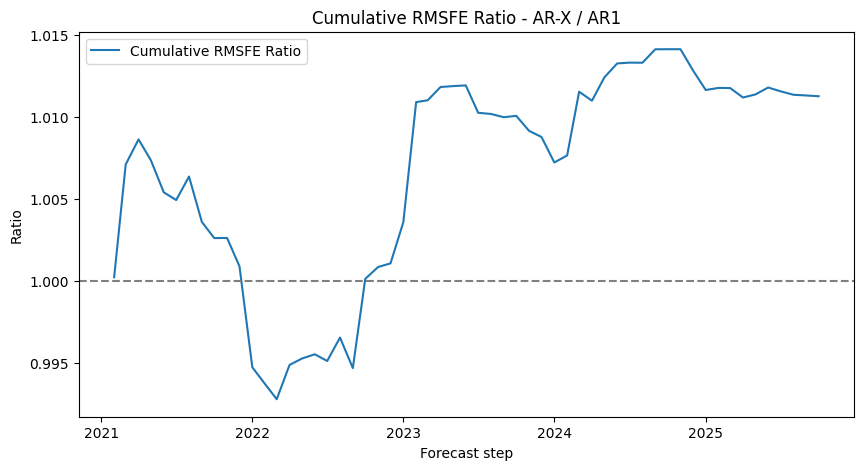

In [251]:
plt.figure(figsize=(10,5))
plt.plot(cum_ratio_trimmed, label="Cumulative RMSFE Ratio")
plt.axhline(1, color="grey", linestyle="--")
plt.title("Cumulative RMSFE Ratio - AR-X / AR1")
plt.ylabel("Ratio")
plt.xlabel("Forecast step")
plt.legend()
plt.show()


### Cumulative RMSFE ratio for Factor model

In [252]:
# Errors for AR(1) and Factor model
errors_ar1 = a_ar1 - f_ar1
errors_fac = a_fac - f_fac

# Cumulative MSE
cum_mse_ar1 = np.cumsum(errors_ar1**2) / np.arange(1, len(errors_ar1)+1)
cum_mse_fac = np.cumsum(errors_fac**2) / np.arange(1, len(errors_fac)+1)

# Cumulative RMSFE
cum_rmsfe_ar1 = np.sqrt(cum_mse_ar1)
cum_rmsfe_fac = np.sqrt(cum_mse_fac)

# Ratio (Factor / AR(1))
cum_ratio_fac = cum_rmsfe_fac / cum_rmsfe_ar1

In [253]:
# Drop first 12 months
cum_ratio_fac_trimmed = cum_ratio_fac.iloc[12:]

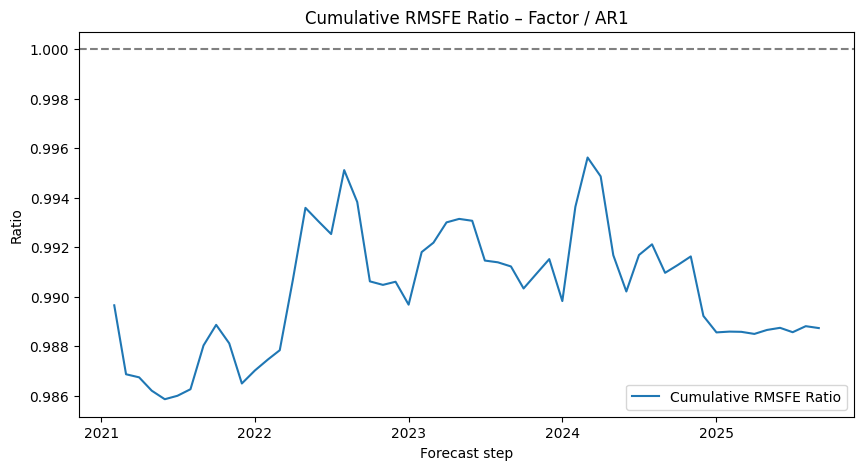

In [254]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(cum_ratio_fac_trimmed, label="Cumulative RMSFE Ratio")
plt.axhline(1, color="grey", linestyle="--")
plt.title("Cumulative RMSFE Ratio – Factor / AR1")
plt.ylabel("Ratio")
plt.xlabel("Forecast step")
plt.legend()
plt.show()

## Comparison plot between AR(1) and AR-X

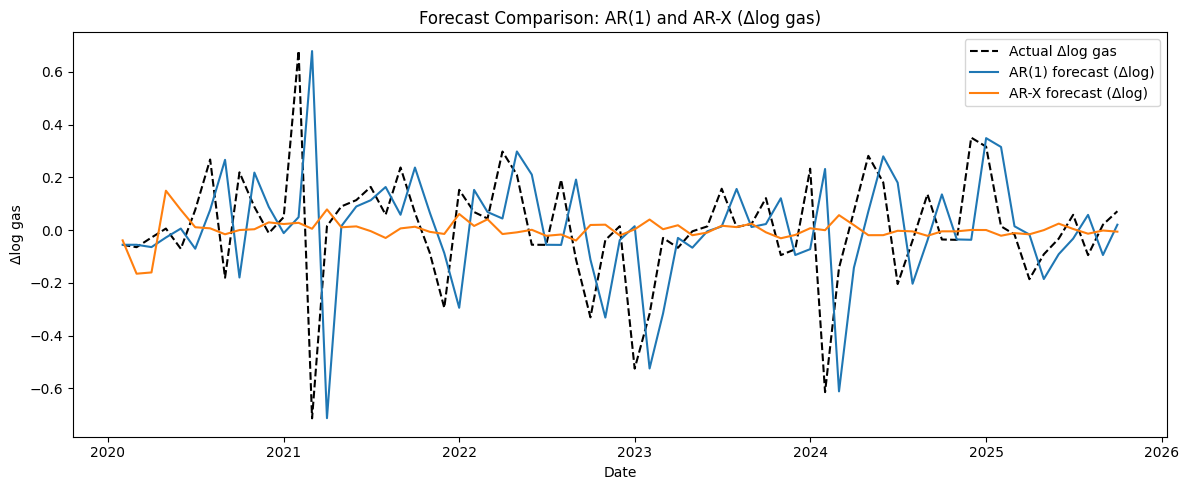

In [255]:
plt.figure(figsize=(12,5))

# --- Convert AR(1) forecasts to Δlog ---
# Δlog = log_t − log_{t-1}
dlog_actual_ar1 = a_ar1.diff().dropna()
dlog_forecast_ar1 = f_ar1.diff().dropna()

# Align indices so they match the AR-X and Factor series
dlog_actual_ar1 = dlog_actual_ar1.reindex(a_arx.index, method='nearest')
dlog_forecast_ar1 = dlog_forecast_ar1.reindex(f_arx.index, method='nearest')

# --- Plot actual Δlog gas ---
plt.plot(a_arx.index, a_arx, label="Actual Δlog gas", color="black", linestyle="--")

# --- Plot forecasts ---
plt.plot(dlog_forecast_ar1.index, dlog_forecast_ar1, 
         label="AR(1) forecast (Δlog)")

plt.plot(f_arx.index, f_arx, 
         label="AR-X forecast (Δlog)")

# Labels & style
plt.title("Forecast Comparison: AR(1) and AR-X (Δlog gas)")
plt.xlabel("Date")
plt.ylabel("Δlog gas")
plt.legend()
plt.tight_layout()
plt.show()

### Comparison plot between AR(1) and Factor model

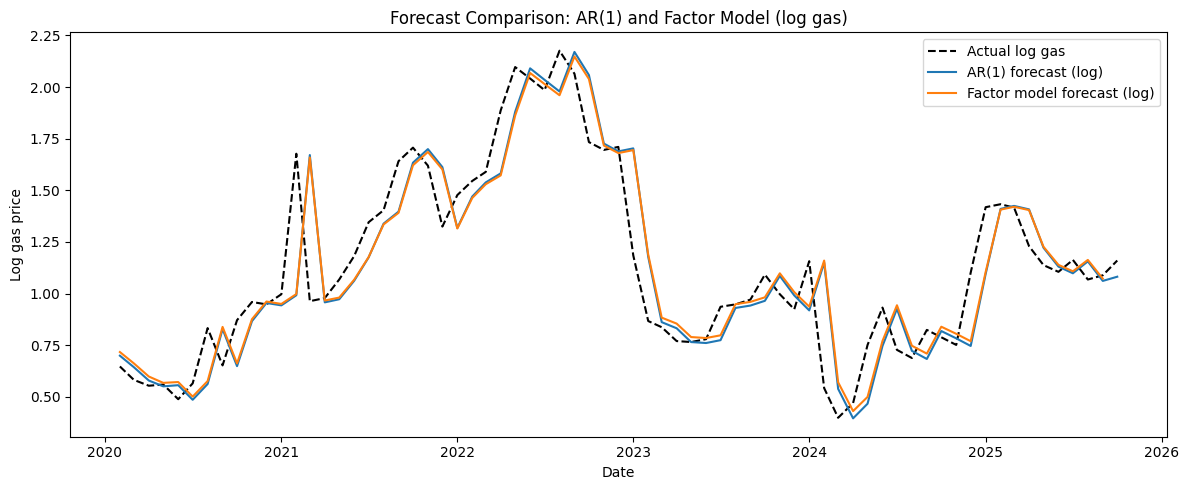

In [256]:
plt.figure(figsize=(12,5))

# 1. Actual log price (from AR(1) actuals)
plt.plot(a_ar1.index, a_ar1, label="Actual log gas", color="black", linestyle="--")


# --- Plot forecasts ---
plt.plot(f_ar1.index, f_ar1, 
         label="AR(1) forecast (log)")

plt.plot(f_fac.index, f_fac, 
         label="Factor model forecast (log)")

# Labels & style
plt.title("Forecast Comparison: AR(1) and Factor Model (log gas)")
plt.xlabel("Date")
plt.ylabel("Log gas price")
plt.legend()
plt.tight_layout()
plt.show()

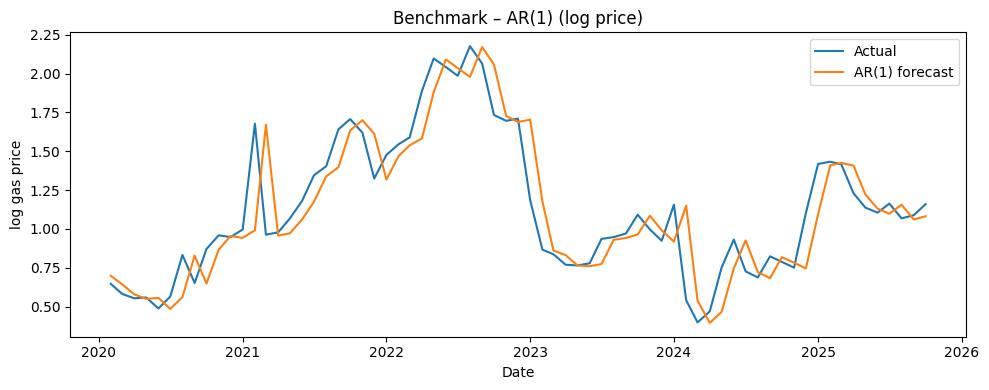

In [257]:
# AR(1) model
plt.figure(figsize=(10,4))
plt.plot(a_ar1.index, a_ar1, label="Actual")
plt.plot(f_ar1.index, f_ar1, label="AR(1) forecast")
plt.title("Benchmark – AR(1) (log price)")
plt.xlabel("Date")
plt.ylabel("log gas price")
plt.legend()
plt.tight_layout()
plt.show()

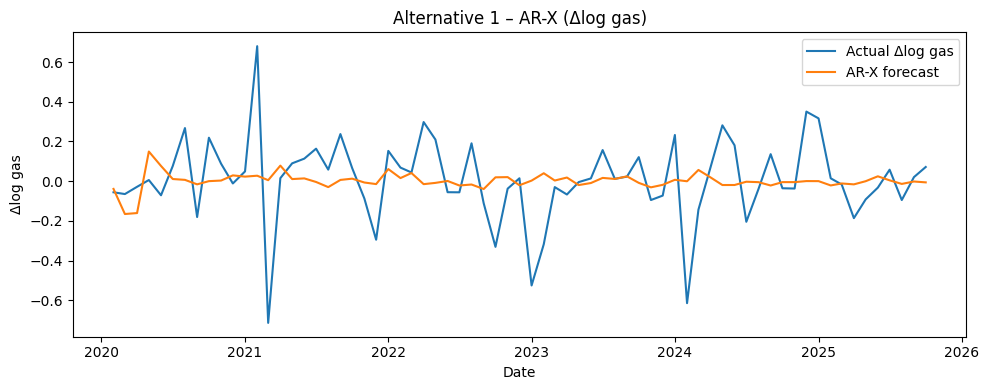

In [258]:
# AR(X) model
plt.figure(figsize=(10,4))
plt.plot(a_arx.index, a_arx, label="Actual Δlog gas")
plt.plot(f_arx.index, f_arx, label="AR-X forecast")
plt.title("Alternative 1 – AR-X (Δlog gas)")
plt.xlabel("Date")
plt.ylabel("Δlog gas")
plt.legend()
plt.tight_layout()
plt.show()


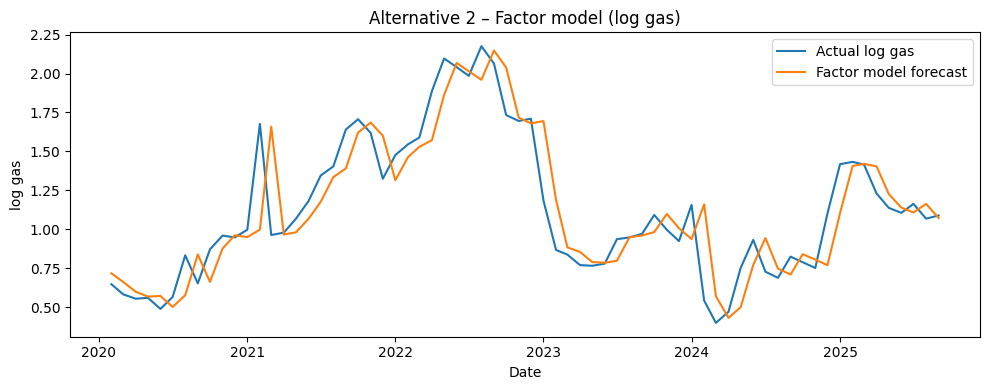

In [259]:
# Factor model
plt.figure(figsize=(10,4))
plt.plot(a_fac.index, a_fac, label="Actual log gas")
plt.plot(f_fac.index, f_fac, label="Factor model forecast")
plt.title("Alternative 2 – Factor model (log gas)")
plt.xlabel("Date")
plt.ylabel("log gas")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Diagnostics

### 5.1 AR(1) benchmark – diagnostics

a) Residuals

In [340]:
# Fit AR(1) on the TRAINING SAMPLE
model_ar1_train = ARIMA(y_train, order=tuple(best_order_uni), trend='n')
fit_ar1_train = model_ar1_train.fit()

# TRUE residuals = training residuals
res_ar1 = fit_ar1_train.resid
res_ar1.name = "res_ar1"

AR(1) residuals – summary:
count    277.000000
mean       0.009696
std        0.152124
min       -0.466291
25%       -0.077017
50%        0.003294
75%        0.090628
max        1.238374
Name: res_ar1, dtype: float64

Mean of residuals (should be close to 0): 0.009695508268422743


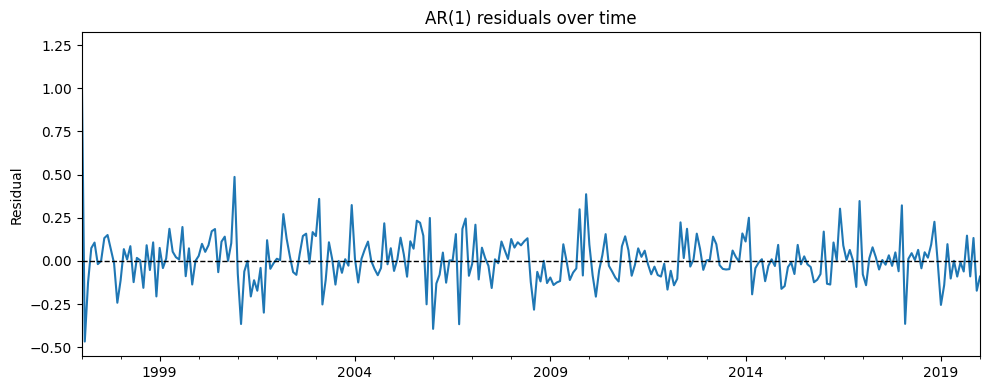

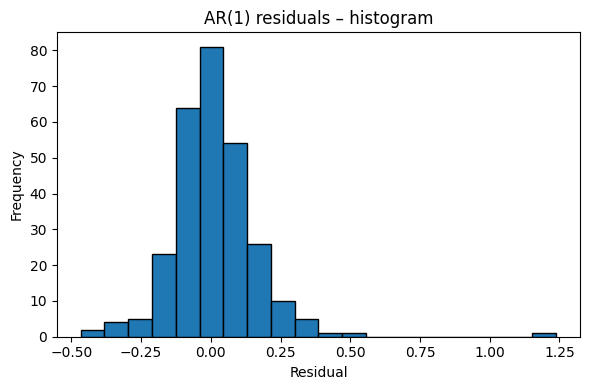

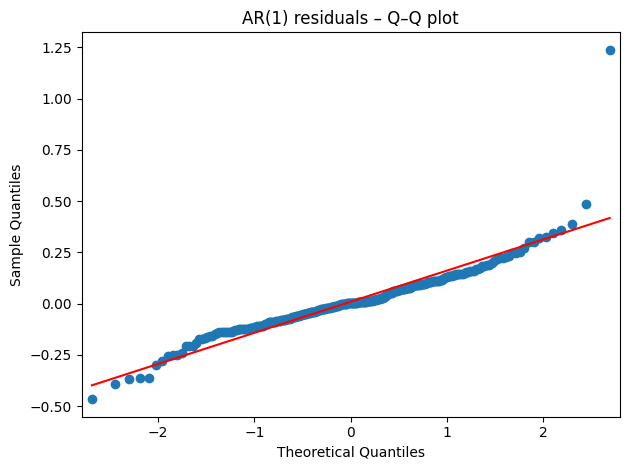

In [341]:
# Summary stats
print("AR(1) residuals – summary:")
print(res_ar1.describe())
print("\nMean of residuals (should be close to 0):", res_ar1.mean())

# Time series plot of residuals
fig, ax = plt.subplots(figsize=(10, 4))
res_ar1.plot(ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1)
ax.set_title("AR(1) residuals over time")
ax.set_ylabel("Residual")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(res_ar1.dropna(), bins=20, edgecolor="k")
ax.set_title("AR(1) residuals – histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Q–Q plot for normality
import statsmodels.api as sm
sm.qqplot(res_ar1.dropna(), line="s")
plt.title("AR(1) residuals – Q–Q plot")
plt.tight_layout()
plt.show()


b) ACF / PACF of residuals

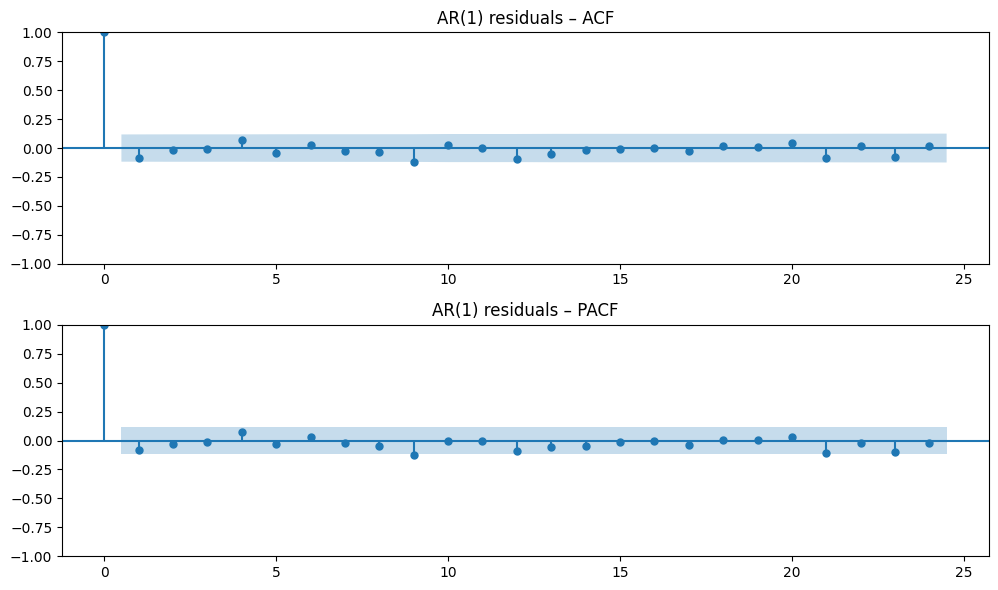

In [342]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(res_ar1.dropna(), lags=24, ax=ax[0])
ax[0].set_title("AR(1) residuals – ACF")
plot_pacf(res_ar1.dropna(), lags=24, ax=ax[1])
ax[1].set_title("AR(1) residuals – PACF")
plt.tight_layout()
plt.show()


c) Stability check for AR(1)

In [343]:
# One-shot AR(1) on full log series
model_ar1_full = ARIMA(y_full.dropna(), order=tuple(best_order_uni), trend='n')
fit_ar1_full = model_ar1_full.fit()

print(fit_ar1_full.summary())

# AR(1) coefficient (phi_1)
phi1 = fit_ar1_full.arparams[0]
print("\nEstimated AR(1) coefficient phi1:", phi1)
print("Is |phi1| < 1 (stationary / stable)? ->", abs(phi1) < 1)

# For AR(1) the root of the characteristic polynomial is 1/phi1
if phi1 != 0:
    root = 1 / phi1
    print("Root of AR(1) polynomial:", root, "|root| >", 1, "->", abs(root) > 1)


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  346
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 159.959
Date:                Sun, 07 Dec 2025   AIC                           -315.918
Time:                        13:59:28   BIC                           -308.225
Sample:                    01-01-1997   HQIC                          -312.855
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9938      0.006    177.695      0.000       0.983       1.005
sigma2         0.0229      0.001     21.108      0.000       0.021       0.025
Ljung-Box (L1) (Q):                   0.09   Jarque-

### 5.2 AR-X model - diagnostics

a) Residuals

In [344]:
# 1) Take ONLY the training part
y2_train = y2_full.iloc[:train_size2]
X2_train = X2_full.iloc[:train_size2]

# 2) Fit ARIMA with exogenous regressors on TRAINING data
model_arx_train = ARIMA(
    y2_train,
    order=tuple(best_order_arx),  # your chosen (p,d,q)
    exog=X2_train
)
fit_arx_train = model_arx_train.fit()

# 3) True residuals = y_train - fitted_y (statsmodels gives them as .resid)
res_arx = fit_arx_train.resid
res_arx.name = "res_arx"

AR-X model residuals – summary:
count    275.000000
mean      -0.000003
std        0.128031
min       -0.431883
25%       -0.075331
50%       -0.007188
75%        0.074183
max        0.536481
Name: res_arx, dtype: float64

Mean of residuals (should be close to 0): -3.1886401512001585e-06


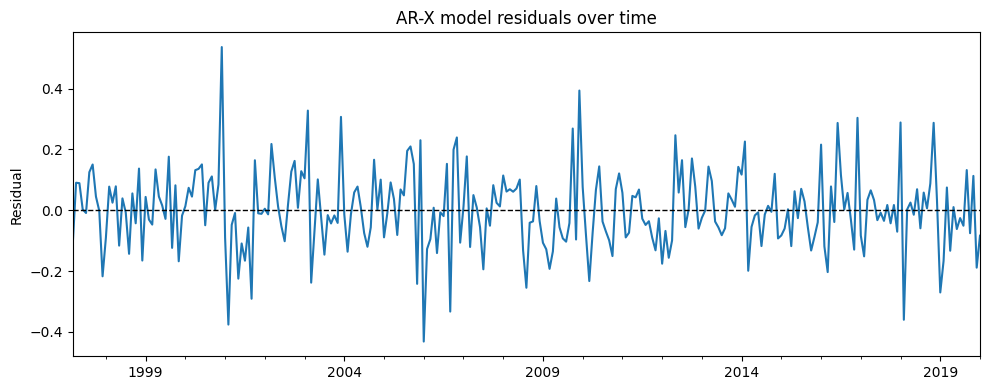

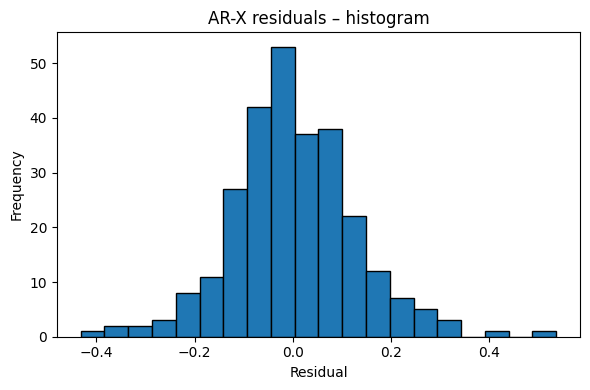

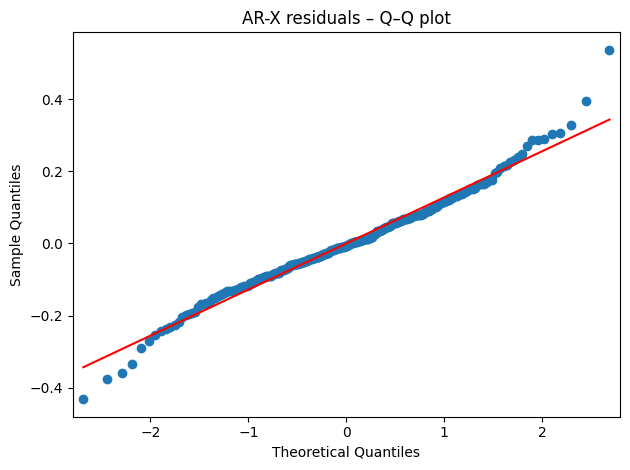

In [345]:
# Summary stats
print("AR-X model residuals – summary:")
print(res_arx.describe())
print("\nMean of residuals (should be close to 0):", res_arx.mean())

# Time series plot of residuals
fig, ax = plt.subplots(figsize=(10, 4))
res_arx.plot(ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1)
ax.set_title("AR-X model residuals over time")
ax.set_ylabel("Residual")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(res_arx.dropna(), bins=20, edgecolor="k")
ax.set_title("AR-X residuals – histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Q–Q plot
sm.qqplot(res_arx.dropna(), line="s")
plt.title("AR-X residuals – Q–Q plot")
plt.tight_layout()
plt.show()

b) ACF / PACF of residuals

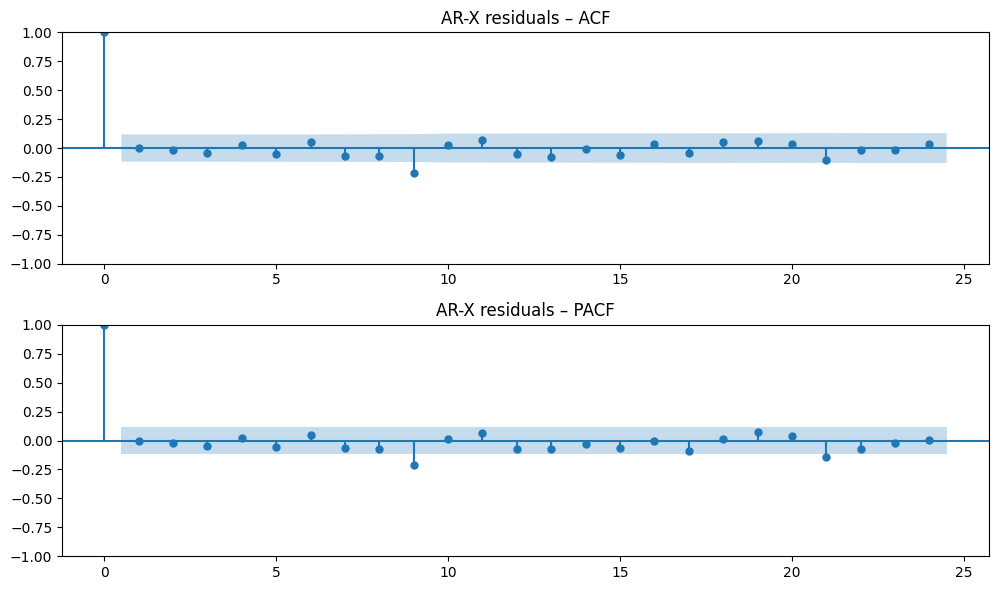

In [346]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(res_arx.dropna(), lags=24, ax=ax[0])
ax[0].set_title("AR-X residuals – ACF")
plot_pacf(res_arx.dropna(), lags=24, ax=ax[1])
ax[1].set_title("AR-X residuals – PACF")
plt.tight_layout()
plt.show()

c) Stability check for AR-X model

In [347]:
# 1. Align and drop missing values
y_arx = y2_full.dropna()
X_arx = X2_full.loc[y_arx.index].dropna()

common_idx = y_arx.index.intersection(X_arx.index)
y_arx = y_arx.loc[common_idx]
X_arx = X_arx.loc[common_idx]

# 2. Estimate ARIMA(1,0,0) with exogenous oil-price diffs
model_arx = ARIMA(y_arx, order=tuple(best_order_arx), exog=X_arx)
arx = model_arx.fit()

print(arx.summary())      # nice formatted table
print(arx.params)         # pandas Series with all coefficients
print(arx.param_names)    # names of each coefficient

                               SARIMAX Results                                
Dep. Variable:                   dlog   No. Observations:                  344
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 169.580
Date:                Sun, 07 Dec 2025   AIC                           -329.159
Time:                        13:59:28   BIC                           -309.956
Sample:                    03-01-1997   HQIC                          -321.511
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.008      0.047      0.962      -0.016       0.016
dlog_oil          0.2364      0.086      2.753      0.006       0.068       0.405
dlog_oil_lag1     0.0187      0.094     

### 5.3 Factor (PC1) model – diagnostics

a) Residuals

In [348]:
# === Factor model residuals (training sample) ===

# Build full y and X
y_fac_all = df_factor["log_gas"]
X_fac_all = sm.add_constant(df_factor[["log_gas_l1", "F_l1"]])

# Restrict to TRAINING sample (first 80%)
y_fac_train = y_fac_all.iloc[:train_size_fac]
X_fac_train = X_fac_all.iloc[:train_size_fac]

# Fit OLS on training data
ols_fac_train = sm.OLS(y_fac_train, X_fac_train).fit()

# True in-sample residuals
res_fac = ols_fac_train.resid
res_fac.name = "res_fac"

Factor model residuals – summary:
count    2.760000e+02
mean    -2.212401e-16
std      1.319932e-01
min     -4.861489e-01
25%     -7.680890e-02
50%     -4.291530e-03
75%      7.921521e-02
max      4.847138e-01
Name: res_fac, dtype: float64

Mean of residuals (should be close to 0): -2.2124009548689713e-16


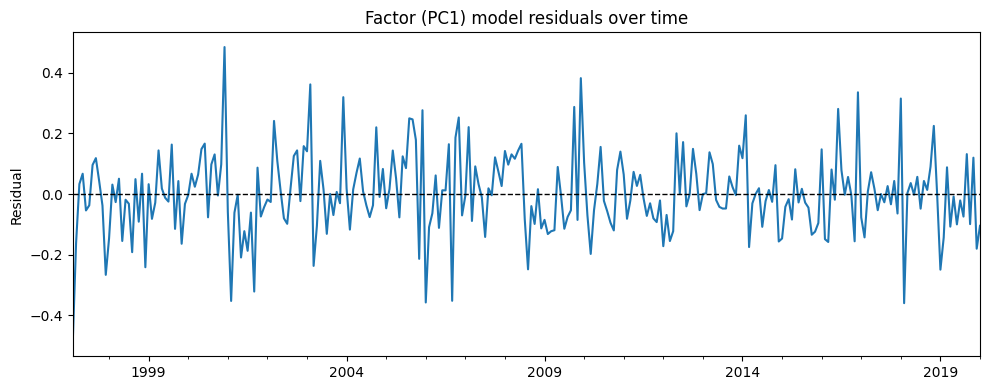

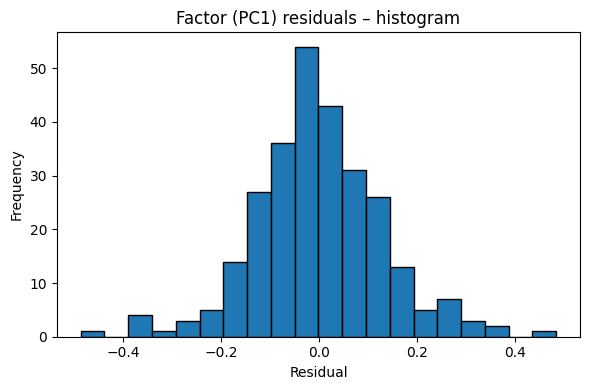

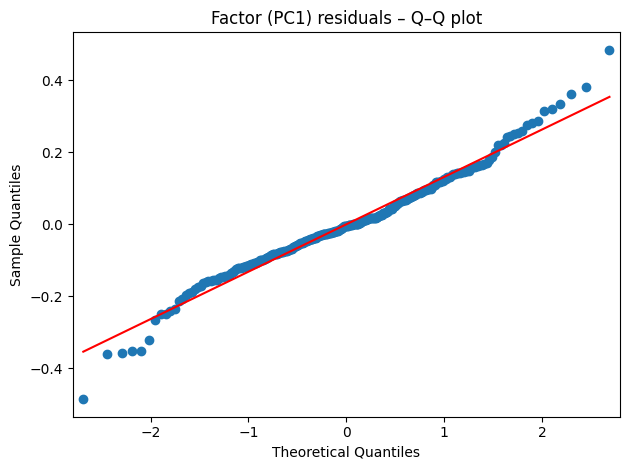

In [349]:
# Summary stats
print("Factor model residuals – summary:")
print(res_fac.describe())
print("\nMean of residuals (should be close to 0):", res_fac.mean())

# Time series plot of residuals
fig, ax = plt.subplots(figsize=(10, 4))
res_fac.plot(ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1)
ax.set_title("Factor (PC1) model residuals over time")
ax.set_ylabel("Residual")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(res_fac.dropna(), bins=20, edgecolor="k")
ax.set_title("Factor (PC1) residuals – histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Q–Q plot
sm.qqplot(res_fac.dropna(), line="s")
plt.title("Factor (PC1) residuals – Q–Q plot")
plt.tight_layout()
plt.show()

b) ACF / PACF of residuals

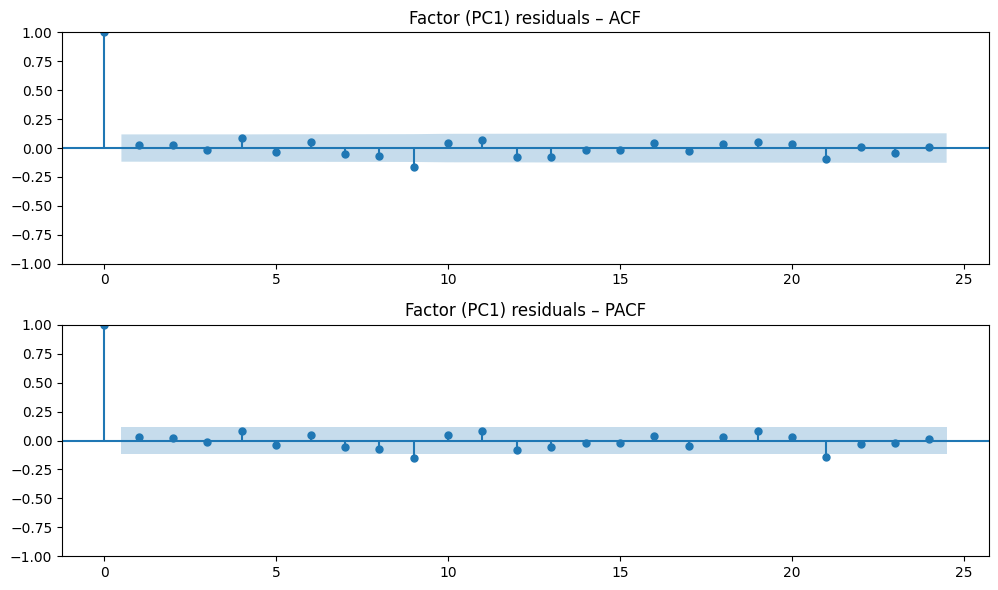

In [350]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(res_fac.dropna(), lags=24, ax=ax[0])
ax[0].set_title("Factor (PC1) residuals – ACF")
plot_pacf(res_fac.dropna(), lags=24, ax=ax[1])
ax[1].set_title("Factor (PC1) residuals – PACF")
plt.tight_layout()
plt.show()

c) Stability check for Factor model

In [351]:
# Full-sample factor model (no rolling) to check stability
y_fac_full = df_factor["log_gas"]
X_fac_full = sm.add_constant(df_factor[["log_gas_l1", "F_l1"]])

ols_fac_full = sm.OLS(y_fac_full, X_fac_full).fit()
print(ols_fac_full.summary())

phi1_fac = ols_fac_full.params["log_gas_l1"]
print("\nCoefficient on log_gas_l1 (phi1 in factor model):", phi1_fac)
print("Is |phi1_fac| < 1 (stable AR part)? ->", abs(phi1_fac) < 1)

                            OLS Regression Results                            
Dep. Variable:                log_gas   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1439.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          5.81e-167
Time:                        13:59:29   Log-Likelihood:                 165.11
No. Observations:                 344   AIC:                            -324.2
Df Residuals:                     341   BIC:                            -312.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0727      0.025      2.949      0.0

### 5.4 Ljung–Box test (residual autocorrelation)

In [352]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [353]:
def ljung_box_report(residuals, lags=12, model_name="model"):
    print(f"\n=== Ljung–Box test for {model_name} residuals (up to lag {lags}) ===")
    lb = acorr_ljungbox(residuals.dropna(), lags=lags, return_df=True)
    print(lb)
    # You mostly comment on the p-values: if they are large, residuals look like white noise.

In [354]:
# AR(1)
ljung_box_report(res_ar1, lags=12, model_name="AR(1) benchmark")


=== Ljung–Box test for AR(1) benchmark residuals (up to lag 12) ===
      lb_stat  lb_pvalue
1    1.899827   0.168098
2    2.006344   0.366714
3    2.032551   0.565678
4    3.528384   0.473576
5    3.954557   0.555977
6    4.196820   0.650061
7    4.414064   0.731039
8    4.746722   0.784272
9    9.003689   0.436934
10   9.149896   0.517940
11   9.150303   0.608021
12  11.563867   0.481310


In [355]:
# AR-X
ljung_box_report(res_arx, lags=12, model_name="AR-X (oil)")


=== Ljung–Box test for AR-X (oil) residuals (up to lag 12) ===
      lb_stat  lb_pvalue
1    0.000016   0.996845
2    0.108183   0.947345
3    0.717303   0.869127
4    0.878141   0.927676
5    1.595402   0.901805
6    2.260472   0.894253
7    3.476733   0.837684
8    4.843751   0.774138
9   17.803899   0.037518
10  18.048618   0.054149
11  19.582824   0.051401
12  20.289847   0.061798


In [356]:
# Factor model
ljung_box_report(res_fac, lags=12, model_name="Factor (PC1)")


=== Ljung–Box test for Factor (PC1) residuals (up to lag 12) ===
      lb_stat  lb_pvalue
1    0.228387   0.632722
2    0.385338   0.824755
3    0.437781   0.932332
4    2.400361   0.662562
5    2.651645   0.753504
6    3.416245   0.755078
7    4.259595   0.749439
8    5.569060   0.695377
9   12.984073   0.163328
10  13.551402   0.194454
11  14.950270   0.184785
12  16.753771   0.159097


### ARCH LM Test

In [357]:
from statsmodels.stats.diagnostic import het_arch

In [358]:
def arch_lm_test(resid, lags=12, model_name=""):
    """
    resid: residual series (pd.Series or np.array)
    lags: number of lags in ARCH LM test
    model_name: string for pretty printing
    """
    resid = pd.Series(resid).dropna()
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid, nlags=lags)
    print(f"{model_name} – ARCH LM test (lags={lags})")
    print(f"  LM stat = {lm_stat:.3f}, p-value = {lm_pvalue:.3f}")
    print(f"  F  stat = {f_stat:.3f}, p-value = {f_pvalue:.3f}\n")
    return lm_stat, lm_pvalue, f_stat, f_pvalue


ARCH LM test for AR(1)

In [359]:
arch_lm_test(res_ar1, lags=12, model_name="AR(1)")

AR(1) – ARCH LM test (lags=12)
  LM stat = 15.914, p-value = 0.195
  F  stat = 1.342, p-value = 0.195



(np.float64(15.914308530310633),
 np.float64(0.19519249300354832),
 1.3417088599695466,
 0.19521907136210653)

ARCH LM test for AR-X (Δlog gas on Δlog oil)

In [360]:
arch_lm_test(res_arx, lags=12, model_name="AR-X (Δlog gas on Δlog oil)")

AR-X (Δlog gas on Δlog oil) – ARCH LM test (lags=12)
  LM stat = 18.930, p-value = 0.090
  F  stat = 1.616, p-value = 0.087



(np.float64(18.92970612562949),
 np.float64(0.09023902241618102),
 1.6158003965049241,
 0.08747463271089173)

ARCH LM test for Factor model (log gas on lagged log gas + factor)

In [361]:
arch_lm_test(res_fac, lags=12, model_name="Factor model (log gas on lagged log gas and factor)")

Factor model (log gas on lagged log gas and factor) – ARCH LM test (lags=12)
  LM stat = 15.380, p-value = 0.221
  F  stat = 1.294, p-value = 0.222



(np.float64(15.38027122151537),
 np.float64(0.22129623576552349),
 1.2939600890241298,
 0.22216108310507682)

### Jarque Bera Test (check normality)

In [362]:
from scipy.stats import jarque_bera

In [363]:
def jb_test(residuals, name):
    jb_stat, p_val = jarque_bera(residuals.dropna())
    print(f"\n=== Jarque–Bera test: {name} ===")
    print(f"JB statistic: {jb_stat:.3f}")
    print(f"p-value:      {p_val:.3f}")
    if p_val > 0.05:
        print("→ Do NOT reject normality at 5% significance level.")
    else:
        print("→ Reject normality at 5% significance level.")


In [364]:
# AR(1)
jb_test(res_ar1, "AR(1) residuals")

# AR-X
jb_test(res_arx, "AR-X residuals")

# Factor model
jb_test(res_fac, "Factor model residuals")


=== Jarque–Bera test: AR(1) residuals ===
JB statistic: 2761.981
p-value:      0.000
→ Reject normality at 5% significance level.

=== Jarque–Bera test: AR-X residuals ===
JB statistic: 29.504
p-value:      0.000
→ Reject normality at 5% significance level.

=== Jarque–Bera test: Factor model residuals ===
JB statistic: 22.193
p-value:      0.000
→ Reject normality at 5% significance level.
